In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
aapl = pd.read_csv('AAPL_CLOSE',index_col='Date',parse_dates=True)
cisco = pd.read_csv('CISCO_CLOSE',index_col='Date',parse_dates=True)
ibm = pd.read_csv('IBM_CLOSE',index_col='Date',parse_dates=True)
amazon = pd.read_csv('AMZN_CLOSE',index_col='Date',parse_dates=True)

In [4]:
stocks = pd.concat([aapl,cisco,ibm,amazon],axis=1)

In [5]:
stocks.columns = ['aapl', 'cisco','ibm','amazon']

In [6]:
stocks.pct_change(1).mean()

aapl      0.000750
cisco     0.000599
ibm       0.000081
amazon    0.001328
dtype: float64

In [7]:
stocks.pct_change(1).corr()

,aapl,cisco,ibm,amazon
aapl,1.000000,0.301990,0.297498,0.235487
cisco,0.301990,1.000000,0.424672,0.284470
ibm,0.297498,0.424672,1.000000,0.258492
amazon,0.235487,0.284470,0.258492,1.000000


In [8]:
log_ret = np.log(stocks/stocks.shift(1))

In [9]:
log_ret.head()

,aapl,cisco,ibm,amazon
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005360,0.019139,-0.004088,-0.008526
2012-01-05,0.011041,-0.003693,-0.004754,0.000563
2012-01-06,0.010400,-0.003707,-0.011547,0.027763
2012-01-09,-0.001587,0.006346,-0.005218,-0.022428


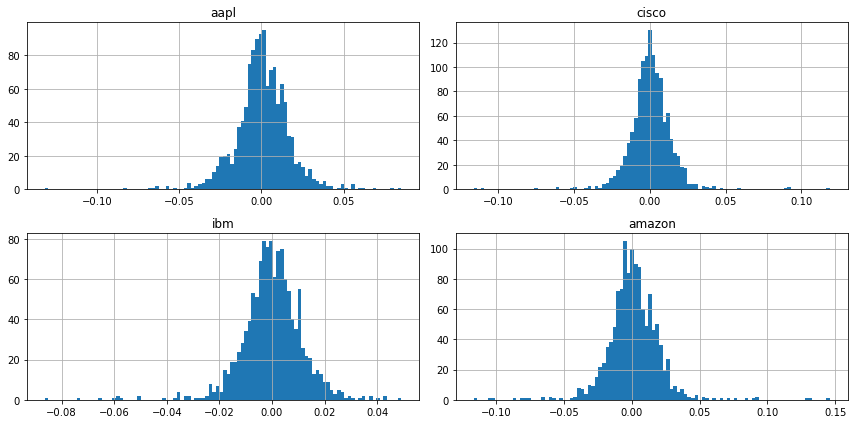

In [10]:
log_ret.hist(bins=100,figsize=(12,6))
plt.tight_layout()

In [11]:
log_ret.mean()

aapl      0.000614
cisco     0.000497
ibm       0.000011
amazon    0.001139
dtype: float64

In [12]:
log_ret.cov()*252

,aapl,cisco,ibm,amazon
aapl,0.068326,0.017854,0.014464,0.018986
cisco,0.017854,0.051381,0.018029,0.019956
ibm,0.014464,0.018029,0.035203,0.014939
amazon,0.018986,0.019956,0.014939,0.094470


In [13]:
np.random.seed(101)

num_ports = 5000
all_weights = np.zeros((num_ports,len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):
    
    # Poids
    weights = np.array(np.random.random(4))
    weights = weights /np.sum(weights)

    # Sauvegarde des poids
    all_weights[ind,:] = weights

    # Rendement attendu
    ret_arr[ind] = np.sum(log_ret.mean()*weights*252)

    # Volatilité attendue
    vol_arr[ind] = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))

    # Ratio de sharpe
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [14]:
sharpe_arr.max()


1.0303260551271307

In [15]:
sharpe_arr.argmax()

1420

In [16]:
all_weights[1420,:]

array([0.26188068, 0.20759516, 0.00110226, 0.5294219 ])

In [17]:
max_sr_set = ret_arr[1420]
max_sr_vol = vol_arr[1420]

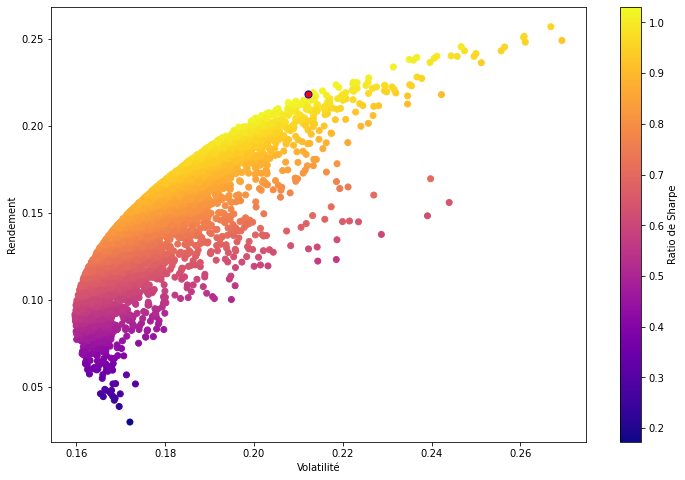

In [18]:
plt.figure(figsize = (12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Ratio de Sharpe')
plt.xlabel('Volatilité')
plt.ylabel('Rendement')

plt.scatter(max_sr_vol,max_sr_set,c='r',s=50,edgecolors='b')

In [30]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean()*weights) * 252
    vol = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
    sr = ret/vol
    
    return np.array([ret,vol,sr])

In [31]:
from scipy.optimize import minimize

In [32]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where ``x`` is an 1-D array with shape (n,) and ``args``
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see her

In [33]:
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

In [34]:
def check_sum(weights):
    # retourne 0 si la somme des poids vaut 1
    return np.sum(weights) -1

In [35]:
cons = ({'type':'eq','fun':check_sum})

In [36]:
bounds = ((0,1),(0,1),(0,1),(0,1))

In [37]:
init_guess = [0.25,0.25,0.25,0.25]

In [38]:
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [39]:
opt_results

     fun: -1.0307168703359362
     jac: array([ 5.64157963e-05,  4.18126583e-05,  3.39921713e-01, -4.45097685e-05])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([2.66289775e-01, 2.04189810e-01, 6.82437505e-17, 5.29520414e-01])

In [49]:
opt_results.x

array([2.66289775e-01, 2.04189810e-01, 6.82437505e-17, 5.29520414e-01])

In [50]:
get_ret_vol_sr(opt_results.x)

array([0.21885916, 0.21233683, 1.03071687])

In [51]:
frontier_y= np.linspace(0,0.3,100)

In [52]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [54]:
frontier_volatility = []

for possible_return in frontier_y:
    cons= ({'type':'eq','fun':check_sum},
          {'type':'eq','fun':lambda w:get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',
                     bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

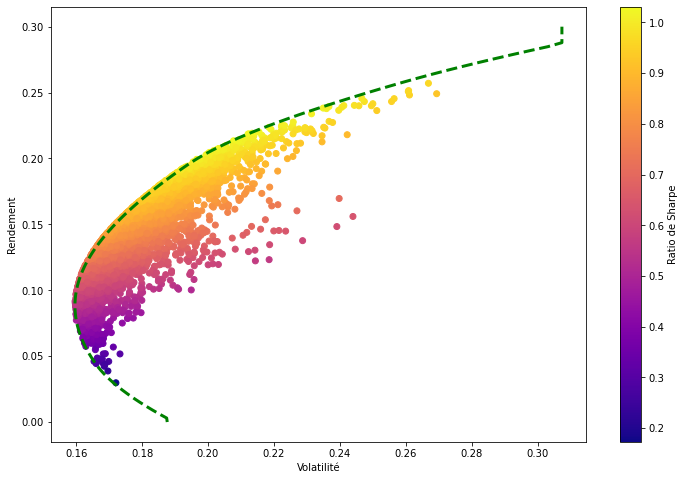

In [57]:
plt.figure(figsize = (12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Ratio de Sharpe')
plt.xlabel('Volatilité')
plt.ylabel('Rendement')

plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)